In [ ]:
# Prepare protein fasta list
import os

final_text = ''
for i in os.listdir('Eukarya_samples/Results'):
    with open(f'Eukarya_samples/Results/{i}', 'r') as text:
        final_text = final_text + text.read()

with open('final.fasta', 'w') as f:
    f.write(final_text)
    f.close()


In [ ]:
# Get more data about obtained proteins
from Bio import SeqIO
from Bio import Entrez
import pandas as pd

S11_table = {'id': [],'sequence': [], 'definition': [],'taxon': [], 'organism': [] }
for i in SeqIO.parse('./Eukarya_samples/final.fasta', 'fasta'):
    S11_table['id'].append(i.id)
    S11_table['sequence'].append(str(i.seq))

for id in S11_table['id']:
    Entrez.email = 'alakhrasyunes@gmail.com'
    handle = Entrez.efetch(db = 'protein', id = id, retmode = 'xml')
    response = Entrez.read(handle)[0]
    S11_table['definition'].append(response['GBSeq_definition'])
    S11_table['taxon'].append(response['GBSeq_taxonomy'])
    S11_table['organism'].append(response['GBSeq_organism'])
    
    # GBSeq_definition
    # GBSeq_division GBSeq_taxonomy GBSeq_organism
S11_table = pd.DataFrame.from_dict(S11_table)
S11_table.to_csv('EuS11.csv', index=False)

In [30]:
# Prepare proteins from UniprotKB and add it to previously obtained results
from Bio import SeqIO
import pandas as pd

S11_table = pd.read_csv('EuS11.csv')
Uniprot_table = {'id': [],'sequence': [], 'definition': [],'taxon': [], 'organism': [] }
for i in SeqIO.parse('./Eukarya_samples/combined.fasta', 'fasta'):
    id_split = i.description.split('); ')
    taxon_split = id_split[0].split(' (')
    Uniprot_table['id'].append(id_split[1])
    Uniprot_table['sequence'].append(str(i.seq))
    Uniprot_table['definition'].append(i.description)
    Uniprot_table['taxon'].append(taxon_split[1])
    Uniprot_table['organism'].append(taxon_split[0])
Uniprot_table = pd.DataFrame.from_dict(Uniprot_table)
to_concat = [Uniprot_table, S11_table]
S11_table = pd.concat(to_concat, axis = 0)
S11_table.to_csv('EuS11.csv', index = False)
Uniprot_table.to_csv('Uniprot_EuS11.csv', index = False)

    


In [37]:
# Treatment of obtained table
import pandas as pd
Uniprot_ids = list(pd.read_csv('Uniprot_EuS11.csv')['id'])
S11_table = pd.read_csv('EuS11.csv')
table_to_delete = S11_table.loc[S11_table['definition'].str.contains('partial')]
S11_table = S11_table.drop(table_to_delete.index)
S11_table = S11_table.loc[
    S11_table['definition'].str.contains('mitochondrial') |
    S11_table['definition'].str.contains('plastid') |
    S11_table['definition'].str.contains('chloroplast') |
    S11_table['definition'].str.contains('mitochondrion') |
    S11_table['id'].isin(Uniprot_ids)
    ]
S11_table.to_csv('EuS11_treated.csv', index = False)

In [38]:
# Find corresponding species for proteins using assembly information
import pandas as pd
import numpy as np

s11_table = pd.read_csv('EuS11_treated.csv')
species_list = pd.read_csv('eukarya_species_list.csv')
treated_table = pd.DataFrame(columns = ['id', 'sequence','definition', 'taxon', 'organism'])
for i in species_list['0']:
    to_concat = [treated_table, s11_table.loc[s11_table['organism'].str.contains(i)]]
    treated_table = pd.concat(to_concat, axis = 0)
treated_table = treated_table.drop_duplicates(subset = ['organism'])
treated_table.to_csv('EuS11_by_species.csv', index = False)

/tmp/ipykernel_4769/2732081754.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  to_concat = [treated_table, s11_table.loc[s11_table['organism'].str.contains(i)]]


In [25]:
# Prepare Ybey table
import pandas as pd

ybey_table = pd.read_csv('../Ybey.tab', sep = '\t')
ybey_table = ybey_table[['entry', 'protein names', 'organism']]
species_list = pd.read_csv('eukarya_species_list.csv')
treated_table = pd.DataFrame(columns=['entry', 'protein names', 'organism'])
for i in species_list['0']:
    to_concat = [treated_table, ybey_table.loc[ybey_table['organism'].str.contains(i)]]
    treated_table = pd.concat(to_concat)
treated_table = treated_table.drop_duplicates(subset = ['organism'])
treated_table.to_csv('EuYbey.csv', index = False)

/tmp/ipykernel_4769/916161857.py:9: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  to_concat = [treated_table, ybey_table.loc[ybey_table['organism'].str.contains(i)]]


In [39]:
# Combine the obtained information (pick ybey and S11 groups)
import pandas as pd
import numpy as np
import re

def us11_analysis(sequence):
    sequence = sequence[-30:]
    # End of the new segment
    scan = re.findall('(?=(D.{8}))', sequence)
    if scan != []:
        # print(scan)
        if scan[-1][7:] in ['NG','DG']: #and len(scan) == 1: 
            return 1 # ng and dg groups
        else:
            return 0 # other groups
    else:
        return 2

ybey_table = pd.read_csv('EuYbey.csv')
s11_table = pd.read_csv('EuS11_by_species.csv')
s11_table['ybey_group'] = np.nan
ybey_table = list(ybey_table['organism'])
for i in range(len(ybey_table)):
    ybey_table[i] = re.sub(' \(.*\)', '', ybey_table[i])
for i in ybey_table:
    s11_table.loc[s11_table['organism'].str.contains(i), 'ybey_group'] = 1
s11_table.loc[s11_table['ybey_group'] != 1, 'ybey_group'] = 0
for i in s11_table.itertuples():
    group = us11_analysis(i.sequence)
    s11_table.loc[s11_table['id'] == i.id, 's11_group'] = group
# s11_table = s11_table.loc[s11_table['s11_group'] != 'NotRepresentative']
s11_table.to_csv('Eu_info_table.csv', index = False)


            ybey_group  s11_group
ybey_group    1.000000   0.581126
s11_group     0.581126   1.000000


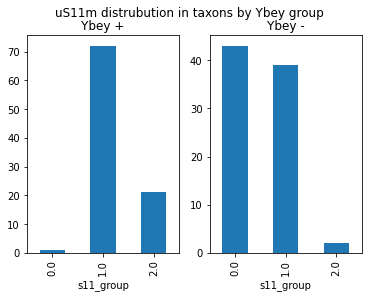

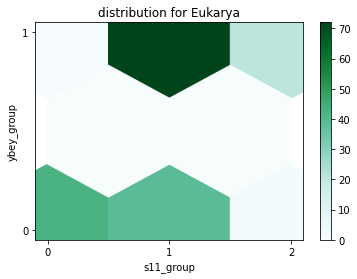

In [40]:
# Visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

info_table = pd.read_csv('Eu_info_table.csv')
# getting visualization by ybey group
fig, axes = plt.subplots(1, 2)
neg_ybey = info_table.loc[info_table['ybey_group'] == 0]
pos_ybey = info_table.loc[info_table['ybey_group'] == 1]
pos_ybey.groupby(['s11_group']).size().plot.bar(subplots = True, ax = axes[0], sharex = False, sharey = False, title = 'uS11m distrubution in taxons by Ybey group')
axes[0].set_title('Ybey +')
neg_ybey.groupby(['s11_group']).size().plot.bar(subplots = True, ax = axes[1], sharex = False, sharey = False)
axes[1].set_title('Ybey -')
plt.savefig('./Plots/ybey_plot.png')

# getting hex plots
info_table = info_table.drop(columns = 'id')
plot = info_table.plot.hexbin(x = 's11_group', y = 'ybey_group', gridsize = (2, 1), title = f'distribution for Eukarya', sharex = False, xticks = (0, 1, 2), yticks = (0, 1) )
corr = info_table.corr()
print(corr)
plot.get_figure().savefig(f'./Plots/Eukarya_plot.png')